# Helper Code (skip this section to see results)

In [2]:
import itertools
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow_probability import distributions as tfd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
DATA_SHAPE = [2]
NOISE_DIMS = 100
LEARNING_RATE = 1e-4
BATCH_SIZE = 128

In [5]:
def make_classifier(data_shape, output_size):
    return keras.Sequential([
        layers.Input(shape=data_shape, dtype='float32'),
        layers.Dense(500, activation='relu'),
        layers.Dense(500, activation='relu'),
        layers.Dense(output_size)
    ])

In [6]:
def make_discriminator(data_shape):
    return keras.Sequential([
        layers.Input(shape=data_shape, dtype='float32'),
        layers.Dense(500, activation='relu'),
        layers.Dense(500, activation='relu'),
        layers.Dense(1)
    ])

In [7]:
def make_generator(data_shape, noise_dims):
    output_flat_size = tf.reduce_prod(data_shape)
    return keras.Sequential([
        layers.Input(shape=(noise_dims,), dtype='float32'),
        layers.Dense(500, activation='relu'),
        layers.Dense(500, activation='relu'),
        layers.Dense(output_flat_size),
        layers.Reshape(data_shape)
    ])

In [8]:
def discriminator_loss(discriminator, real_data, fake_data):
    real_scores = discriminator(real_data)
    fake_scores = discriminator(fake_data)
    
    cross_entropy = losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_scores), real_scores)
    fake_loss = cross_entropy(tf.zeros_like(fake_scores), fake_scores)
    return real_loss + fake_loss


def generator_loss(discriminator, classifier, fake_data, beta):
    
    kl = uniform_prior_to_classifier_kl(classifier, fake_data)
    kl = tf.reduce_mean(kl)
    
    cross_entropy = losses.BinaryCrossentropy(from_logits=True)
    fake_scores = discriminator(fake_data)
    gan_loss = cross_entropy(tf.ones_like(fake_scores), fake_scores)
    return gan_loss - (beta * kl)


def uniform_prior_to_classifier_kl(classifier, fake_data):
    classifier_probs = tf.nn.softmax(classifier(fake_data))
    
    num_classes = classifier_probs.get_shape().as_list()[-1]
    uniform_probs = tf.fill(classifier_probs.shape, 1.0/float(num_classes))
    
    kl = losses.kullback_leibler_divergence(uniform_probs, classifier_probs)
    return kl


def classifier_loss(classifier, real_data, real_labels, fake_data, beta):
    kl = tf.reduce_mean(uniform_prior_to_classifier_kl(classifier, fake_data))
    
    preds = classifier(real_data)
    cross_entropy = losses.CategoricalCrossentropy(from_logits=True)
    classification_loss = cross_entropy(real_labels, preds)
    
    return classification_loss - (beta * kl)


def grads_and_vars(tape, target, variables):
    grads = tape.gradient(target, variables)
    return zip(grads, variables)


@tf.function
def train_step(classifier, generator, discriminator, 
               real_data, real_labels, 
               d_optimizer, g_optimizer, c_optimizer,
               noise_dims, beta):
    batch_size = real_data.get_shape().as_list()[0]
    noise_shape = [batch_size, noise_dims]
    
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape, \
                tf.GradientTape() as c_tape:
        fake_data = generator(tf.random.normal(shape=noise_shape))
        d_loss = discriminator_loss(discriminator, real_data, fake_data)
        
        fake_data = generator(tf.random.normal(shape=noise_shape))
        g_loss = generator_loss(discriminator, classifier, fake_data, beta)
        
        fake_data = generator(tf.random.normal(shape=noise_shape))
        c_loss = classifier_loss(classifier, real_data, real_labels, 
                                 fake_data, beta)
        
    d_grads_and_vars = grads_and_vars(d_tape, d_loss, 
            discriminator.trainable_variables)
    d_optimizer.apply_gradients(d_grads_and_vars)
    
    g_grads_and_vars = grads_and_vars(g_tape, g_loss, 
            generator.trainable_variables)
    g_optimizer.apply_gradients(g_grads_and_vars)
    
    c_grads_and_vars = grads_and_vars(c_tape, c_loss, 
            classifier.trainable_variables)
    c_optimizer.apply_gradients(c_grads_and_vars)
    
    return d_loss, g_loss, c_loss


def train_model(classifier, generator, discriminator, 
               dataset, n_epoch, noise_dims, beta,
               d_optimizer, g_optimizer, c_optimizer):
    d_loss_metric = keras.metrics.Mean('discriminator_loss', dtype=tf.float32)
    g_loss_metric = keras.metrics.Mean('generator_loss', dtype=tf.float32)
    c_loss_metric = keras.metrics.Mean('classifier_loss', dtype=tf.float32)
    
    epoch_logs = []
    for epoch_idx in tqdm(range(n_epoch)):
        for batch_data, batch_labels in dataset:
            d_loss, g_loss, c_loss = train_step(
                classifier, generator, discriminator,
                batch_data, batch_labels,
                d_optimizer, g_optimizer, c_optimizer,
                noise_dims, beta
            )
            
            d_loss_metric(d_loss)
            g_loss_metric(g_loss)
            c_loss_metric(c_loss)
        
        epoch_log_row = {
            'discriminator_loss': d_loss_metric.result().numpy(),
            'generator_loss': g_loss_metric.result().numpy(),
            'classifier_loss': c_loss_metric.result().numpy()
        }
        epoch_logs.append(epoch_log_row)
    
    return epoch_logs
        

In [9]:
def sample_2d_2_cluster_data(batch_size):
    cluster_dists = [
        tfd.MultivariateNormalDiag(loc=[-1.5, -1.5], scale_diag=[0.5, 0.5]),
        tfd.MultivariateNormalDiag(loc=[1, 1], scale_diag=[0.5, 0.5])
    ]
    cluster_probs = [0.5, 0.5]
    num_clusters = len(cluster_probs)
    labels = np.random.choice(list(range(num_clusters)), size=batch_size, 
            p=cluster_probs)
    
    features = np.zeros(shape=(batch_size, 2), dtype=np.float32)
    for i in range(batch_size):
        features[i] = cluster_dists[labels[i]].sample().numpy()
    
    labels = tf.one_hot(labels, depth=num_clusters).numpy()
    
    return features, labels

# Generate a toy 2D dataset with two classes 
(using a mixture of two normal  Gaussian distributions)

In [10]:
train_features, train_labels = sample_2d_2_cluster_data(10000)

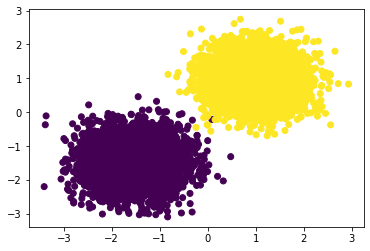

In [11]:
plt.scatter(train_features[:, 0], train_features[:, 1], c=np.argmax(train_labels, axis=1))

# Create model

In [12]:
train_size = train_features.shape[0]
train_dataset = tf.data.Dataset \
    .from_tensor_slices((train_features, train_labels)) \
    .shuffle(train_size) \
    .batch(BATCH_SIZE) \
    .prefetch(1)

In [13]:
g_optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
d_optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
c_optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)

In [14]:
classifier = make_classifier(DATA_SHAPE, 2)
discriminator = make_discriminator(DATA_SHAPE)
generator = make_generator(DATA_SHAPE, NOISE_DIMS)

In [15]:
epoch_logs = train_model(classifier, generator, discriminator, 
           train_dataset, n_epoch=100, noise_dims=NOISE_DIMS,
           beta=1.0, d_optimizer=d_optimizer, g_optimizer=g_optimizer,
           c_optimizer=c_optimizer)

100%|██████████| 100/100 [01:43<00:00,  1.03s/it]


# Example of fake 'out-of-distribution' data sampled from the learned generator

Blue points are real data and orange are points created by the generator

In [16]:
fake_data = generator(tf.random.normal(shape=[1000, NOISE_DIMS])).numpy()

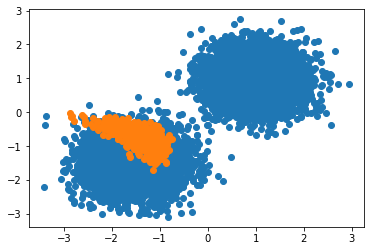

In [17]:
plt.scatter(train_features[:, 0], train_features[:, 1])
plt.scatter(fake_data[:, 0], fake_data[:, 1])

In [18]:
epoch_logs_df = pd.DataFrame(epoch_logs)

# Learning Curves

Discriminator Loss (y-axis) vs Training Iteration (x-axis)

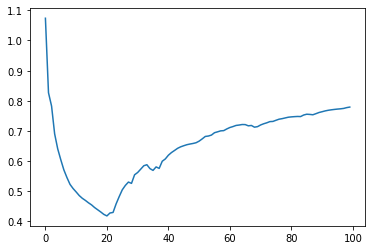

In [19]:
plt.plot(epoch_logs_df.discriminator_loss)

Generator Loss (y-axis) vs Training Iteration (x-axis)

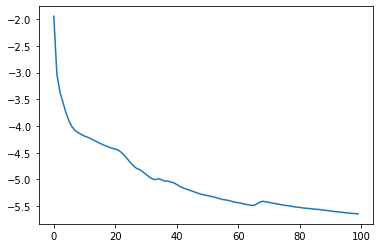

In [20]:
plt.plot(epoch_logs_df.generator_loss)

Classifier Loss (y-axis) vs Training Iteration (x-axis)

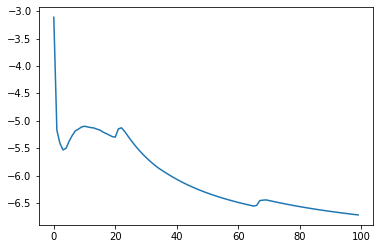

In [21]:
plt.plot(epoch_logs_df.classifier_loss)

# Inspecting the classifier's entropy (uncertainty)

In [22]:
def discrete_entropy(logits):
    probs = tf.math.softmax(logits)
    log_probs = tf.math.log(probs)
    return - tf.reduce_sum(probs * log_probs, axis=-1)

In [23]:
test_features, test_labels = sample_2d_2_cluster_data(1000)

In [24]:
unif_feats = tfd.Uniform(low=[-5, -5], high=[5, 5]).sample(BATCH_SIZE).numpy()
aug_test_feats = np.concatenate(
        [test_features, unif_feats], axis=0)
aug_test_labels = np.concatenate(
    [
        np.argmax(test_labels, axis=1),
        np.full(BATCH_SIZE, -1)
    ],
    axis=0)
aug_test_labels += 1

In [25]:
pred_logits = classifier(aug_test_feats).numpy()
pred_entropys = discrete_entropy(pred_logits).numpy()
pred_labels = np.argmax(pred_logits, axis=1)

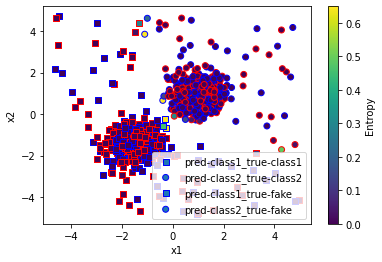

In [27]:
pred_class_markers = ['s', 'o', '^']
pred_class_marker_labels = {'s': 'pred-class1', 'o': 'pred-class2', '^': 'error'}
pred_markers = np.asarray([pred_class_markers[l] for l in pred_labels])
true_class_edge_colors = ['black', 'blue', 'red']
true_class_edge_color_labels = {'black': 'true-fake', 'blue': 'true-class1', 'red': 'true-class2'}
true_edge_colors = np.asarray([true_class_edge_colors[l] for l in aug_test_labels])
attr_combos = itertools.product(pred_class_markers, true_class_edge_colors)
#attr_combos = list(zip(pred_markers, true_edge_colors))
for marker_symbol, edge_color in set(attr_combos):
    mask = (pred_markers == marker_symbol) & (true_edge_colors == edge_color)
    if np.sum(mask) > 0:
      _label = f'{pred_class_marker_labels[marker_symbol]}_{true_class_edge_color_labels[edge_color]}'
      plt.scatter(aug_test_feats[mask, 0], aug_test_feats[mask, 1], 
              c=pred_entropys[mask], marker=marker_symbol,
              edgecolors=true_edge_colors, label=_label)
color_bar = plt.colorbar()
color_bar.set_label('Entropy')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='best')